# Regression - Prediciting Life Expectancy for US

### Now it is time to use other models to reduce the complexity of our baseline model by using several feature selection techniques. The aim here is to reduce the amount of features for our 'client', there will no doubt be some tradeoff between model accuracy and complexity.

As we can see above, we get a R2 scores of 83% for a single train-test split model and 88% if we conduct a cross-validation with 5 splits. This however might result in a model that is too complex noting the number of features we have. Let's conduct two different ways of selecting only the best features:
- filter methods
    - low variance
    - Pearson's Correlation (Given majority of our features are continuous)
- wrapper methods
    - Recurvsive Feature Elimination
    - Stepwise Selection
- embedded methods 
    - Lasso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from functions import *

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
df_clean = pd.read_csv('clean_data.csv', index_col=[0])

In [3]:
to_drop = ['State_Abbreviation', 'Name', 'Life_expectancy']
X = df_clean.drop(to_drop, axis = 1)
y = df_clean['Life_expectancy']

Split into training and testing dataset, followed by a subsequent split within the training bucket into training and validation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [5]:
print ('Total training data:', len(X_train_subset))
print ('Total validation data:', len(X_val))
print ('Total test date:', len(X_test))
print ('Total data:', len(X))
print ('Cross check:',  len(X) == len(X_train_subset) + len(X_val) + len(X_test))

Total training data: 1767
Total validation data: 589
Total test date: 786
Total data: 3142
Cross check: True


Create a dataframe to store all model outcomes which will be useful to derive a conclusion at a later stage

In [6]:
all_model_summary_df = pd.DataFrame([], columns = ['model', 'R2_test', 'AIC', 'n_features', '>0.05_pvalues'])
all_model_summary_df['model'] = ['Baseline', 'Basic - Top Correlation',
                                 'Filter', 
                                 'Wrappper - RFE', 'Wrappper - Stepwise',
                                 'Embedded - Lasso',
                                ]

### 1. Baseline model - All available features

This is a very basic model which accounts for all 76 features purely using the X_train dataset (no validation)

In [7]:
baseline_OLS = OLS(y_train, add_constant(X_train)).fit()

baseline_predictions = baseline_OLS.predict(add_constant(X_test))
baseline_train_r2 = baseline_OLS.rsquared

baseline_test_r2 = r2_score(y_test, baseline_predictions)

In [8]:
baseline_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     336.0
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:56:49   Log-Likelihood:                -3002.6
No. Observations:                2356   AIC:                             6151.
Df Residuals:                    2283   BIC:                             6572.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Release_Year                                                             0.0465      0.002     23.221      0.000       0.043       0.050
County_Ranked_(Yes=1/No=0)                                               0.1642      0.167      0.983      0.326      -0.163       0.492
Premature_death                                                      -6.975e-05   2.91e-05     -2.395      0.017      -0.000   -1.26e-05
Poor_or_fair_health                                                      1.4903      2.134      0.698      0.485      -2.695       5.676
Poor_physical_health_days                                               -0.4139      0.274     -1.509      0.131      -0.952       0.124
Poor_mental_health_days                                                 -0.1955      0.212     -0.921      0.357      -0.612       0.221
Low_birthweight                                                         -2.5356      1.309     -1.937      0.053      -5.103       0.032
Adult_smoking                                                           -1.1421      1.516     -0.753      0.451      -4.115       1.830
Adult_obesity                                                           -1.3662      0.725     -1.885      0.059      -2.787       0.055
Food_environment_index                                                  -0.1856      0.309     -0.600      0.548      -0.792       0.421
Physical_inactivity                                                      0.0319      0.721      0.044      0.965      -1.382       1.445
Access_to_exercise_opportunities                                        -0.3188      0.117     -2.730      0.006      -0.548      -0.090
Excessive_drinking                                                       2.7308      1.100      2.483      0.013       0.574       4.887
Alcohol-impaired_driving_deaths                                         -0.1606      0.121     -1.325      0.185      -0.398       0.077
Sexually_transmitted_infections                                         -0.0002      0.000     -1.901      0.057      -0.000     7.5e-06
Teen_births                                                              0.0037      0.003      1.354      0.176      -0.002       0.009
Uninsured                                                               85.8872     11.877      7.231      0.000      62.595     109.179
Primary_care_physicians                                               -347.5367     78.684     -4.417      0.000    -501.837    -193.236
Dentists                                                                -6.9809     76.603     -0.091      0.927    -157.200     143.238
Mental_health_providers                                              

Now, let's check the R2 of the train and test sets as well as plot the residuals

Baseline Train R-Squared: 0.91
Baseline Test R-Squared: 0.84


Check for Homoscedasticity Assumption


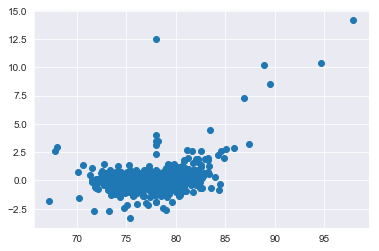

Check for Residuals Normality


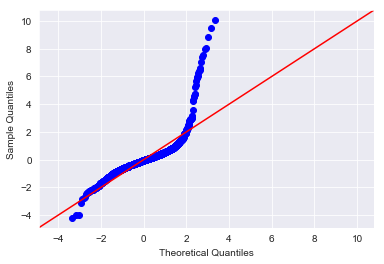

In [9]:
baseline_errors = y_test - baseline_predictions

print ('Baseline Train R-Squared:', round(baseline_train_r2, 2))
print ('Baseline Test R-Squared:', round(baseline_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = baseline_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(baseline_OLS.resid, dist=stats.norm, line='45', fit=True)

Rule of thumb threshold is VIF at the level of 2.5, meaning if the VIF is above 2.5 you should consider there is effect of multicollinearity on your fitted model

In [10]:
X_baseline = X_train
X_baseline['Intercept'] = 1

Baseline_VIF = pd.DataFrame()
Baseline_VIF["variables"] = X_baseline.columns
Baseline_VIF["VIF"] = [variance_inflation_factor(X_baseline.values, i) for i in range(X_baseline.shape[1])]

baseline_correlated_features = sum(Baseline_VIF['VIF'] > 5)
baseline_correlated_features

31

In [11]:
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'n_features'] = len(baseline_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'AIC'] = baseline_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', 'R2_test'] = baseline_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Baseline', '>0.05_pvalues'] = sum(baseline_OLS.pvalues > 0.05)

In [12]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.835919,6151.3,73,46
1,Basic - Top Correlation,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 2. Basic - Features with Highest Correlation with Target

Given we've blindly included all features in the baseline model, let's try and narrow these down to only include features which are highly correlated with 'Life Expectancy'. First, we initiated a correlation matrix and set our target correlation threshold to 0.65.

In [13]:
initial_matrix = abs(df_clean.corr().Life_expectancy)

target_correlation_threshold = 0.65

final = list(initial_matrix[(initial_matrix.sort_values(ascending=False) > target_correlation_threshold)].index)
final.remove('Life_expectancy')
final

['Premature_death',
 'Poor_physical_health_days',
 'Adult_smoking',
 'Premature_age-adjusted_mortality',
 'Frequent_physical_distress',
 'Frequent_mental_distress']

Using a 0.65 threshold, we've narrowed down our features from 76 to 6 features. Using these 6 features, let's create another OLS model and evaluate its performance.

In [14]:
basic_correlation_OLS = OLS(y_train, add_constant(X_train[final])).fit()

basic_predictions = basic_correlation_OLS.predict(add_constant(X_test[final]))
basic_train_r2 = basic_correlation_OLS.rsquared

basic_test_r2 = r2_score(y_test, basic_predictions)

In [15]:
basic_correlation_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3007.
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:56:50   Log-Likelihood:                -3343.8
No. Observations:                2356   AIC:                             6702.
Df Residuals:                    2349   BIC:                             6742.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               88.5765      0.157    565.278      0.000      88.269      88.884
Premature_death                   2.108e-05   2.55e-05      0.826      0.409   -2.89e-05    7.11e-05
Poor_physical_health_days           -1.1767      0.163     -7.224      0.000      -1.496      -0.857
Adult_smoking                       -6.4842      1.060     -6.117      0.000      -8.563      -4.405
Premature_age-adjusted_mortality    -0.0242      0.001    -37.377      0.000      -0.026      -0.023
Frequent_physical_distress          58.1358      5.056     11.498      0.000      48.221      68.050
Frequent_mental_distress           -21.7542      4.001     -5.438      0.000     -29.599     -13.909
==============================================================================
Omnibus:                     2330.297   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171800.511
Skew:                           4.630   Prob(JB):                         0.00
Kurtosis:                      43.796   Cond. No.                     2.27e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like the 'Premature_death' feature is not significant according its p-value. Let's re-run the model again excluding this feature.

In [16]:
final.remove('Premature_death')
final

['Poor_physical_health_days',
 'Adult_smoking',
 'Premature_age-adjusted_mortality',
 'Frequent_physical_distress',
 'Frequent_mental_distress']

In [17]:
basic_correlation_OLS = OLS(y_train, add_constant(X_train[final])).fit()

basic_predictions = basic_correlation_OLS.predict(add_constant(X_test[final]))
basic_train_r2 = basic_correlation_OLS.rsquared

basic_test_r2 = r2_score(y_test, basic_predictions)

In [18]:
basic_correlation_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3609.
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:56:50   Log-Likelihood:                -3344.2
No. Observations:                2356   AIC:                             6700.
Df Residuals:                    2350   BIC:                             6735.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               88.5568      0.155    571.848      0.000      88.253      88.861
Poor_physical_health_days           -1.1993      0.161     -7.469      0.000      -1.514      -0.884
Adult_smoking                       -6.5190      1.059     -6.155      0.000      -8.596      -4.442
Premature_age-adjusted_mortality    -0.0238      0.000    -84.558      0.000      -0.024      -0.023
Frequent_physical_distress          58.4547      5.041     11.596      0.000      48.570      68.340
Frequent_mental_distress           -21.2764      3.958     -5.375      0.000     -29.038     -13.514
==============================================================================
Omnibus:                     2347.908   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           176856.921
Skew:                           4.682   Prob(JB):                         0.00
Kurtosis:                      44.399   Cond. No.                     1.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Good, dropping the feature does not impact our R2. Let's now conduct further analysis on the R-Squares, Residuals' Homoscedasticity and Normality

Basic Train R-Squared: 0.88
Basic Test R-Squared: 0.82


Check for Homoscedasticity Assumption


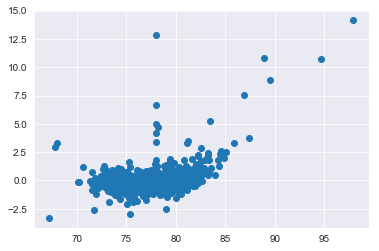

Check for Residuals Normality


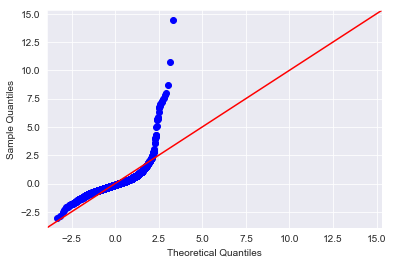

In [19]:
basic_errors = y_test - basic_predictions

print ('Basic Train R-Squared:', round(basic_train_r2, 2))
print ('Basic Test R-Squared:', round(basic_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = basic_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(basic_correlation_OLS.resid, dist=stats.norm, line='45', fit=True)

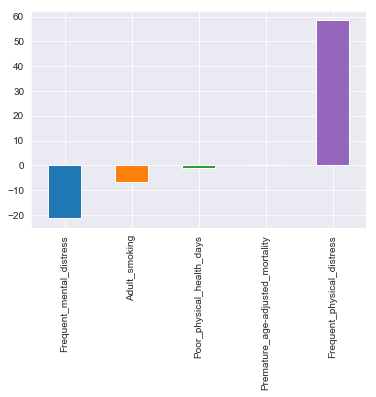

In [20]:
coef_basic = basic_correlation_OLS.params.sort_values()
coef_basic[:5].plot(kind = 'bar', figsize = (6,4))
plt.show()

In [21]:
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'n_features'] = len(basic_correlation_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'AIC'] = basic_correlation_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', 'R2_test'] = basic_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Basic - Top Correlation', '>0.05_pvalues'] = sum(basic_correlation_OLS.pvalues > 0.05)

In [22]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.835919,6151.3,73,46
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,NaN,NaN,NaN,NaN
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


Just by using the 6 top correlated features, we get almost similar results to our Baseline model and is much more user friendly for our client!

### 3. Filter Method - drop features with no or low variance & high correlation with other features

One of the pitfalls of the above method is that we might have potentially ignored other useful features that might be of use to our client. Also, the baseline model might include various highly correlated features which violates the assumptions of a regression model. As such, let's try out best to find a middle ground by using the filter methods, first by:

- dropping features with no or low variance. These features typically do not add much predictive value
- dropping features which are highly correlated

Let's start of by dropping features with no or low variance. We can use Sklearn's variance threshold tool to remove features with low threshold (we set it at 0.025).

In [23]:
variance_threshold = 0.00

low_var_filter = VarianceThreshold(threshold = variance_threshold)
low_var_filter.fit(X_train)

VarianceThreshold(threshold=0.0)

In [24]:
dropped_cols = X_train.columns[low_var_filter.get_support() == False]
print ('Number of low variance features:', len(dropped_cols))

Number of low variance features: 2


In [25]:
High_Var_Features = X_train.drop(dropped_cols, axis = 1)

Now we have removed them, let's further narrow down features by excluding highly correlated features. We have defined highly correlated features as those with pearson's r of 0.7 or more

In [26]:
corr_matrix = High_Var_Features.corr()
correlated_features = set()

corr_threshold = 0.7

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

correlated_features

{'%_not_proficient_in_English',
 'Adult_smoking',
 'Children_eligible_for_free_or_reduced_price_lunch',
 'Children_in_poverty',
 'Diabetes_prevalence',
 'Food_insecurity',
 'Frequent_mental_distress',
 'Frequent_physical_distress',
 'Limited_access_to_healthy_foods',
 'Median_household_income',
 'Percentage_of_households_with_high_housing_costs',
 'Poor_mental_health_days',
 'Poor_physical_health_days',
 'Premature_age-adjusted_mortality',
 'Severe_housing_cost_burden',
 'Teen_births',
 'Uninsured_adults',
 'Uninsured_children'}

In [27]:
High_Var_Features_Low_Corr = High_Var_Features.drop(list(correlated_features), axis = 1)

In [28]:
filter_OLS = OLS(y_train, add_constant(X_train[High_Var_Features_Low_Corr.columns])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test[High_Var_Features_Low_Corr.columns]))
filter_train_r2 = filter_OLS.rsquared

filter_test_r2 = r2_score(y_test, filter_predictions)

In [29]:
filter_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     298.5
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:56:51   Log-Likelihood:                -3439.3
No. Observations:                2356   AIC:                             6989.
Df Residuals:                    2301   BIC:                             7306.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   86.5615      2.631     32.897      0.000      81.402      91.722
County_Ranked_(Yes=1/No=0)                                               0.7491      0.195      3.851      0.000       0.368       1.131
Premature_death                                                         -0.0008   1.74e-05    -44.881      0.000      -0.001      -0.001
Poor_or_fair_health                                                      0.1945      1.349      0.144      0.885      -2.452       2.840
Low_birthweight                                                         -6.1250      1.526     -4.014      0.000      -9.117      -3.133
Adult_obesity                                                           -1.6766      0.802     -2.091      0.037      -3.249      -0.105
Food_environment_index                                                   0.0020      0.032      0.062      0.950      -0.061       0.065
Physical_inactivity                                                     -3.3447      0.819     -4.082      0.000      -4.952      -1.738
Access_to_exercise_opportunities                                        -0.0536      0.139     -0.386      0.700      -0.326       0.219
Excessive_drinking                                                       2.5315      1.188      2.131      0.033       0.202       4.861
Alcohol-impaired_driving_deaths                                         -0.0884      0.145     -0.611      0.541      -0.372       0.195
Sexually_transmitted_infections                                         -0.0005      0.000     -3.433      0.001      -0.001      -0.000
Uninsured                                                               -1.3925      0.731     -1.906      0.057      -2.825       0.040
Primary_care_physicians                                               -301.5995     93.378     -3.230      0.001    -484.712    -118.487
Dentists                                                               -83.8419     90.947     -0.922      0.357    -262.188      94.504
Mental_health_providers                                                -54.1855     18.435     -2.939      0.003     -90.337     -18.034
Preventable_hospital_stays                                           -4.184e-05   1.42e-05     -2.955      0.003   -6.96e-05   -1.41e-05
Mammography_screening                                                    0.0574      0.400      0.143      0.886      -0.728       0.843
Flu_vaccinations                                                         0.2196      0.307      0.716      0.474      -0.382       0.821
High_school_graduation                                               

Looks like there are more features with high p-values. Once again, let's remove them and refit the model

In [30]:
updated_filter_features = filter_OLS.pvalues
updated_filter_features = updated_filter_features[updated_filter_features < 0.05]
updated_filter_features.drop('const', axis = 0, inplace = True)
updated_filter_features.index

Index(['County_Ranked_(Yes=1/No=0)', 'Premature_death', 'Low_birthweight',
       'Adult_obesity', 'Physical_inactivity', 'Excessive_drinking',
       'Sexually_transmitted_infections', 'Primary_care_physicians',
       'Mental_health_providers', 'Preventable_hospital_stays', 'Some_college',
       'Unemployment', 'Children_in_single-parent_households',
       'Social_associations', 'Violent_crime', 'Injury_deaths',
       'Air_pollution_-_particulate_matter', 'Severe_housing_problems',
       'Driving_alone_to_work', 'HIV_prevalence', 'Motor_vehicle_crash_deaths',
       'Other_primary_care_providers', 'Residential_segregation_-_Black/White',
       '%_below_18_years_of_age', '%_65_and_older', '%_Asian',
       '%_Native_Hawaiian/Other_Pacific_Islander', '%_Females', '%_Rural'],
      dtype='object')

In [31]:
filter_OLS = OLS(y_train, add_constant(X_train[updated_filter_features.index])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test[updated_filter_features.index]))
filter_train_r2 = filter_OLS.rsquared

filter_test_r2 = r2_score(y_test, filter_predictions)

In [32]:
filter_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     497.7
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:56:51   Log-Likelihood:                -3563.4
No. Observations:                2356   AIC:                             7187.
Df Residuals:                    2326   BIC:                             7360.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       87.9808      0.774    113.742      0.000      86.464      89.498
County_Ranked_(Yes=1/No=0)                   0.4629      0.190      2.439      0.015       0.091       0.835
Premature_death                             -0.0008   1.64e-05    -47.235      0.000      -0.001      -0.001
Low_birthweight                             -3.3412      1.442     -2.317      0.021      -6.169      -0.513
Adult_obesity                               -1.7249      0.767     -2.248      0.025      -3.230      -0.220
Physical_inactivity                         -5.6412      0.791     -7.129      0.000      -7.193      -4.089
Excessive_drinking                           0.6896      1.060      0.651      0.515      -1.389       2.768
Sexually_transmitted_infections              0.0003      0.000      1.957      0.050   -5.56e-07       0.001
Primary_care_physicians                   -344.5089     91.577     -3.762      0.000    -524.091    -164.927
Mental_health_providers                    -63.1366     18.339     -3.443      0.001     -99.100     -27.173
Preventable_hospital_stays               -3.944e-05   1.44e-05     -2.745      0.006   -6.76e-05   -1.13e-05
Some_college                                 1.0740      0.315      3.406      0.001       0.456       1.692
Unemployment                                 0.1274      1.812      0.070      0.944      -3.427       3.681
Children_in_single-parent_households         0.1949      0.355      0.549      0.583      -0.501       0.891
Social_associations                         -0.0109      0.004     -2.699      0.007      -0.019      -0.003
Violent_crime                               -0.0005      0.000     -2.943      0.003      -0.001      -0.000
Injury_deaths                               -0.0067      0.002     -4.484      0.000      -0.010      -0.004
Air_pollution_-_particulate_matter          -0.1527      0.016     -9.365      0.000      -0.185      -0.121
Severe_housing_problems                     -0.7609      0.764     -0.995      0.320      -2.260       0.738
Driving_alone_to_work                       -3.1880      0.446     -7.146      0.000      -4.063      -2.313
HIV_prevalence                               0.0002      0.000      1.442      0.149   -8.82e-05       0.001
Motor_vehicle_crash_deaths                  -0.0044      0.004     -1.160      0.246      -0.012       0.003
Other_primary_care_providers                34.8585     52.514      0.664      0.507     -68.120     137.837
Residential_segregation_-_Black/White       -0.0007      0.002     -0.391      0.696      -0.005       0.003
%_below_18_years_of_age                      0.8925      1.102      0.810      0.418      -1.269       3.054
%_65_and_older                 

Filter Train R-Squared: 0.86
Filter Test R-Squared: 0.78


Check for Homoscedasticity Assumption


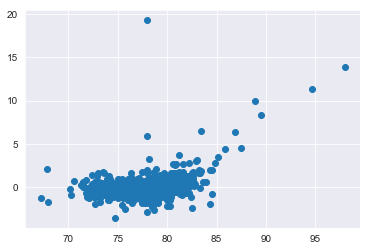

Check for Residuals Normality


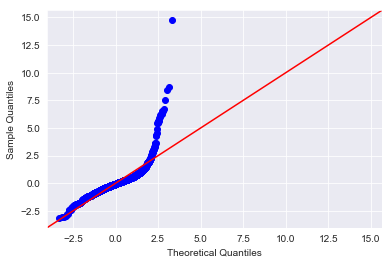

In [33]:
filter_errors = y_test - filter_predictions

print ('Filter Train R-Squared:', round(filter_train_r2, 2))
print ('Filter Test R-Squared:', round(filter_test_r2, 2))

print ('\n')

print ('Check for Homoscedasticity Assumption')
plt.figure(figsize = (6,4))
plt.scatter(x = y_test, y = filter_errors)
plt.show()

print ('Check for Residuals Normality')
fig = sm.graphics.qqplot(filter_OLS.resid, dist=stats.norm, line='45', fit=True)

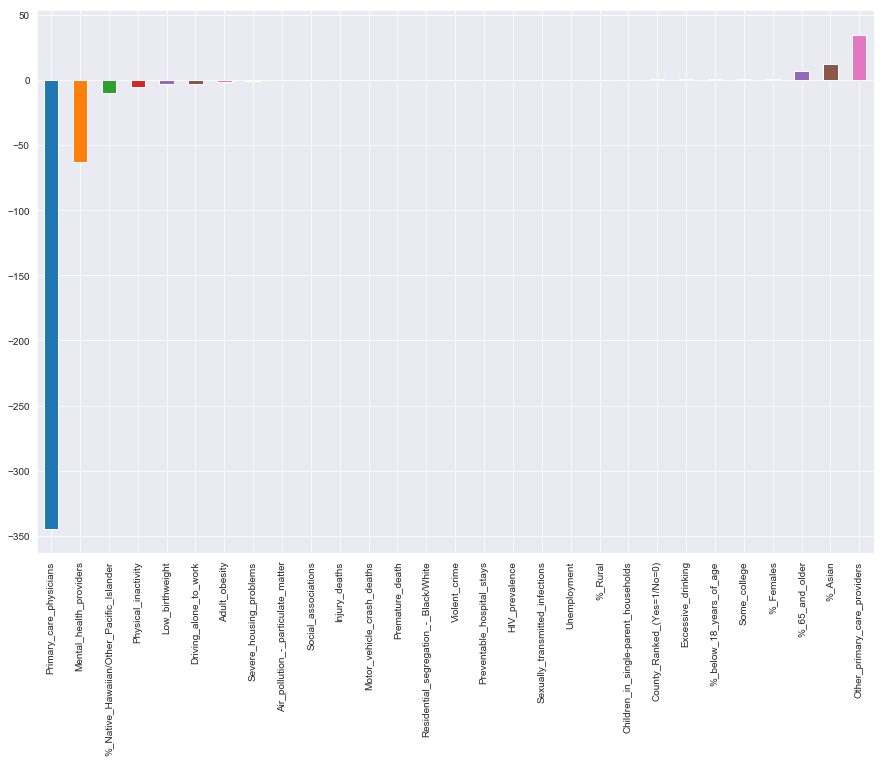

In [34]:
coef_filter = filter_OLS.params.sort_values()
coef_filter[:-1].plot(kind = 'bar', figsize = (15,10))
plt.show()

In [35]:
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'n_features'] = len(filter_OLS.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'AIC'] = filter_OLS.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', 'R2_test'] = filter_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Filter', '>0.05_pvalues'] = sum(filter_OLS.pvalues > 0.05)

In [36]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.835919,6151.3,73,46
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.778847,7186.9,30,12
3,Wrappper - RFE,NaN,NaN,NaN,NaN
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 4. Wrapper - Recursive Feature Elimination

In [37]:
from sklearn.feature_selection import RFECV, RFE

In [38]:
linreg = LinearRegression()
rfecv = RFECV(linreg, step = 1, scoring='r2', cv=10)
rfecv.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

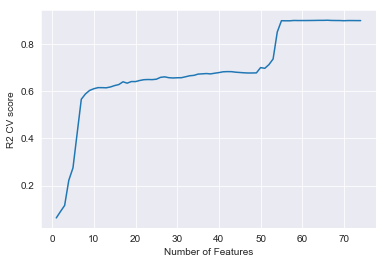

In [39]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of Features')
plt.ylabel('R2 CV score')
plt.show()

In [40]:
to_include = X_train.columns[rfecv.get_support()]

In [41]:
RFE_test_r2 = statsmodel_regression(X_train[to_include], add_constant(X_test[to_include]), y_train, y_test)[0]
RFE_estimator = statsmodel_regression(X_train[to_include], add_constant(X_test[to_include]), y_train, y_test)[1]

In [42]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'n_features'] = len(RFE_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'AIC'] = RFE_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', 'R2_test'] = RFE_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - RFE', '>0.05_pvalues'] = sum(RFE_estimator.pvalues > 0.05)

In [43]:
all_model_summary_df

,model,R2_test,AIC,n_features,>0.05_pvalues
0,Baseline,0.835919,6151.3,73,46
1,Basic - Top Correlation,0.817139,6700.37,6,0
2,Filter,0.778847,7186.9,30,12
3,Wrappper - RFE,0.84,6169.38,67,39
4,Wrappper - Stepwise,NaN,NaN,NaN,NaN
5,Embedded - Lasso,NaN,NaN,NaN,NaN


### 5. Stepwise Selection - Combination of Forward and Backward feature selection

In [44]:
stepwise_columns = stepwise_selection(X_train, y_train, threshold_in = 0.01, verbose=True)

Add  Premature_age-adjusted_mortality with p-value 0.0
Add  Release_Year                   with p-value 0.0
Add  Intercept                      with p-value 0.0
Add  Driving_alone_to_work          with p-value 2.96713e-41
Add  %_not_proficient_in_English    with p-value 2.65547e-15
Add  %_below_18_years_of_age        with p-value 3.73109e-17
Add  Air_pollution_-_particulate_matter with p-value 2.38055e-16
Add  %_Asian                        with p-value 7.32641e-13
Add  Severe_housing_problems        with p-value 1.03946e-10
Add  %_Non-Hispanic_white           with p-value 2.8868e-11
Add  Child_mortality                with p-value 2.04289e-08
Add  Limited_access_to_healthy_foods with p-value 3.52036e-07
Add  Income_inequality              with p-value 0.000105851
Add  Primary_care_physicians        with p-value 7.91373e-05
Add  %_Native_Hawaiian/Other_Pacific_Islander with p-value 0.00039003
Add  Some_college                   with p-value 0.00056378
Add  Violent_crime                

In [45]:
stepwise_test_r2 = statsmodel_regression(X_train[stepwise_columns], X_test[stepwise_columns], y_train, y_test)[0]
stepwise_estimator = statsmodel_regression(X_train[stepwise_columns], X_test[stepwise_columns], y_train, y_test)[1]

KeyError: "['Intercept'] not in index"

In [ ]:
stepwise_estimator.params.sort_values().plot(kind = 'bar', figsize = (18,10))
plt.show()

In [ ]:
len(stepwise_estimator.resid)

In [ ]:
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'n_features'] = len(stepwise_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'AIC'] = stepwise_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', 'R2_test'] = stepwise_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Wrappper - Stepwise', '>0.05_pvalues'] = sum(stepwise_estimator.pvalues > 0.05)

In [ ]:
all_model_summary_df

### 6. Embedded - Lasso L2 Regression

First we set the all the hyperparameters we are interested in tuning, primarily the 'penalizing' parameters (alpha). The GridSearch function will be able to obtain the best parameters for us by evaluating them using R2 score.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

model = Lasso()
lasso_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
                'fit_intercept': [True, False],
                'normalize' : [True, False]}

grid_obj = GridSearchCV(estimator = model, 
                        param_grid = lasso_params, 
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train_subset, y_train_subset)
grid_obj.best_params_

Looks like the best alpha level is 0.05. Let's use the above best selected parameters and train it on our subset of X_train data and subsequently test them on the validation dataset.

In [ ]:
final_lasso = grid_obj.best_estimator_.fit(X_train_subset, y_train_subset)

train_predictions = final_lasso.predict(X_train_subset)
val_predictions = final_lasso.predict(X_val)
test_predictions = final_lasso.predict(X_test)

print ('Train R2 score of:', round(r2_score(y_train_subset, train_predictions),2))
print ('Validation R2 score of:', round(r2_score(y_val, val_predictions),2))
print ('Test R2 score of:', round(r2_score(y_test, test_predictions),2))

Not bad at all. Now let's explore the coefficients that the Lasso model chose and plot them.

In [ ]:
coef = pd.Series(final_lasso.coef_, index = X_train_subset.columns)
final_coef = coef[coef != 0]
final_coef.sort_values(ascending = False, inplace=True)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

final_coef.plot(kind = "bar", figsize=(15,5))
plt.title("Coefficients in the Lasso Model")
plt.show()

How about the residuals?

In [ ]:
preds = pd.DataFrame({"preds":final_lasso.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]

preds.plot(x = "preds", y = "residuals", kind = "scatter", figsize=(15,10))
plt.title('Lasso Residual Plots')
plt.show()

In [ ]:
X2 = X_train[final_coef.index]
X2['Intercept'] = 1

vif = pd.DataFrame()
vif["variables"] = X2.columns
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]

vif

In [ ]:
final_coef

Apply the 20 selected features from the lasso model into our usual OLS model to obtain further information

In [ ]:
final_lasso_test_r2 = statsmodel_regression(X_train[final_coef.index], add_constant(X_test[final_coef.index]), y_train, y_test)[0]
final_lasso_estimator = statsmodel_regression(X_train[final_coef.index], add_constant(X_test[final_coef.index]), y_train, y_test)[1]

In [ ]:
final_lasso_estimator.pvalues > 0.05

In [ ]:
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'n_features'] = len(final_lasso_estimator.pvalues)
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'AIC'] = final_lasso_estimator.aic
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', 'R2_test'] = final_lasso_test_r2
all_model_summary_df.loc[all_model_summary_df.model == 'Embedded - Lasso', '>0.05_pvalues'] = sum(final_lasso_estimator.pvalues > 0.05)

In [ ]:
all_model_summary_df